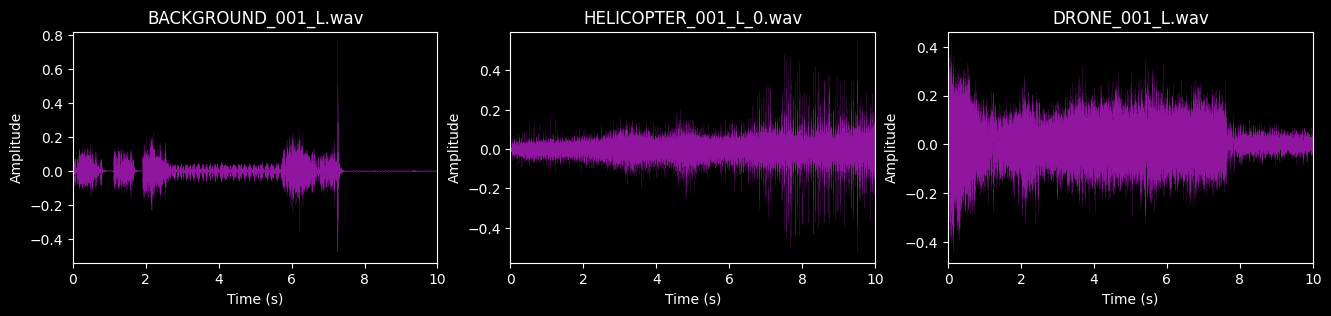

In [15]:
import matplotlib.pyplot as plt

from hs_hackathon_drone_acoustics import EXAMPLES_DIR
from hs_hackathon_drone_acoustics.base import AudioWaveform  # Custom waveform representation.
from hs_hackathon_drone_acoustics.plot import plot_waveform  # Custom function used to plot waveforms.

from pathlib import Path

EXAMPLES_DIR = Path("/home/henrik/Documents/EDTH/CPH2025/edth-copenhagen-drone-acoustics/data/examples")

example_files = list(EXAMPLES_DIR.glob("*.wav"))
fig, axes = plt.subplots(1, len(example_files), figsize=(16, 3))
for ifile, example_file in enumerate(example_files):
    waveform = AudioWaveform.load(example_file)
    plot_waveform(waveform, axis=axes[ifile])
    axes[ifile].set_title(example_file.name)

From these examples, we can already see differences between the different classes: the helicopter and drones classes appear to have white noise-like contents throughout, while the background has periods of silence.


To verify this observation, it is useful to plot the variations in a waveform's frequency components over time, also known as a **spectrogram**. Spectrograms are obtained by taking the magnitude of a [Short-Time Fourier Transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform). Code to plot a spectrogram from a wavform is provided in the `hs_hackathon_drone_acoustics.plot.plot_spectrogram` function.

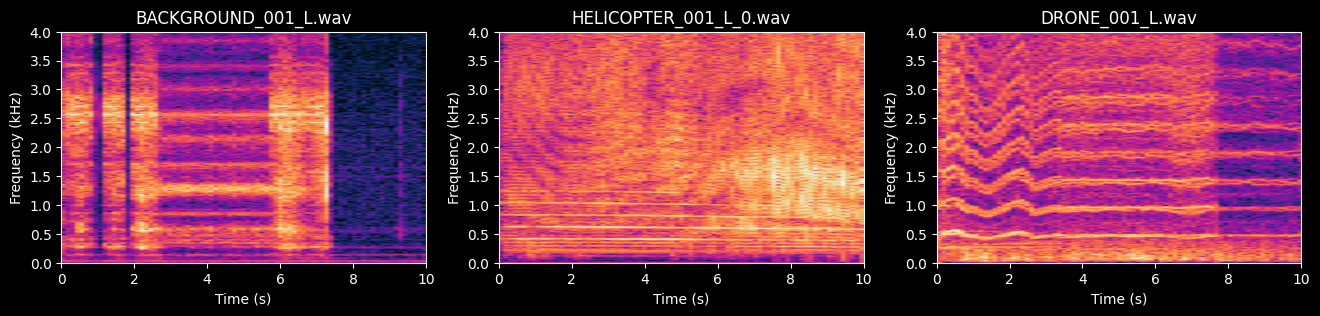

In [16]:
from hs_hackathon_drone_acoustics.plot import plot_spectrogram  # Custom function to plot spectrograms.

fig, axes = plt.subplots(1, len(example_files), figsize=(16, 3))
for ifile, example_file in enumerate(example_files):
    waveform = AudioWaveform.load(example_file)
    plot_spectrogram(waveform, axis=axes[ifile])
    axes[ifile].set_title(example_file.name)
    axes[ifile].set_ylim([0, 4])

### Extracting audio features

Clearly, the various classes have different waveform characteristics. It may be useful for classification to extract waveform features which can capture and summarise differentiating characteristics for each class. For example, we may want to extract the waveform's energy.

In [17]:
import numpy as np


def extract_waveform_energy(waveform: AudioWaveform) -> float:
    energy = np.linalg.vector_norm(waveform.data, ord=2)
    return energy


for example_file in example_files:
    waveform = AudioWaveform.load(example_file)
    energy = extract_waveform_energy(waveform)
    print(f"Energy in {example_file.name}: {energy}.")

Energy in BACKGROUND_001_L.wav: 19.396041870117188.
Energy in HELICOPTER_001_L_0.wav: 30.61870765686035.
Energy in DRONE_001_L.wav: 42.54238510131836.


Another very common set of features to extract in audio processing are [Mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). They capture frequency information in the signal in a more condensed manner than the spectrogram above.

In [18]:
import librosa
from numpy.typing import NDArray


def extract_mean_mfccs(waveform: AudioWaveform, n_mfcc: int = 20) -> NDArray[np.float64]:
    mfccs = librosa.feature.mfcc(y=waveform.data.numpy(), sr=waveform.sample_rate, n_mfcc=n_mfcc)
    mean_mfccs = np.mean(mfccs, axis=1)
    return mean_mfccs


for example_file in example_files:
    waveform = AudioWaveform.load(example_file)
    mfccs = extract_mean_mfccs(waveform)
    print(f"Mean MFCC[0:5] for {example_file.name}: {mfccs[0:5]}.")

Mean MFCC[0:5] for BACKGROUND_001_L.wav: [-411.1024     135.53679      3.7244055    9.2797      -0.7335443].
Mean MFCC[0:5] for HELICOPTER_001_L_0.wav: [-243.90651   167.75426   -40.48547    34.049526  -23.43798 ].
Mean MFCC[0:5] for DRONE_001_L.wav: [-188.06148   126.241234  -32.448082   35.920147  -25.51138 ].


These features can be used to classify audio waveforms: e.g. the energy in the background class is lower than in the helicopter class, which itself is lower than in the drone class. This is the case for the selected examples but may not be true when considering the broader dataset. In the next section, we will show how features can be extracted from entire datasets and used to train a simple classifier.

## Baseline classification

### Creating datasets

To manage your dataset structure, we provide in `base.py` a custom `AudioDataset` class which loads waveforms from files and associates them with the correct label. Make sure you have followed the data download guide in Phase 1: Model Training in the README!

159
367
529
Train dataset size: 540
Validation dataset size: 180


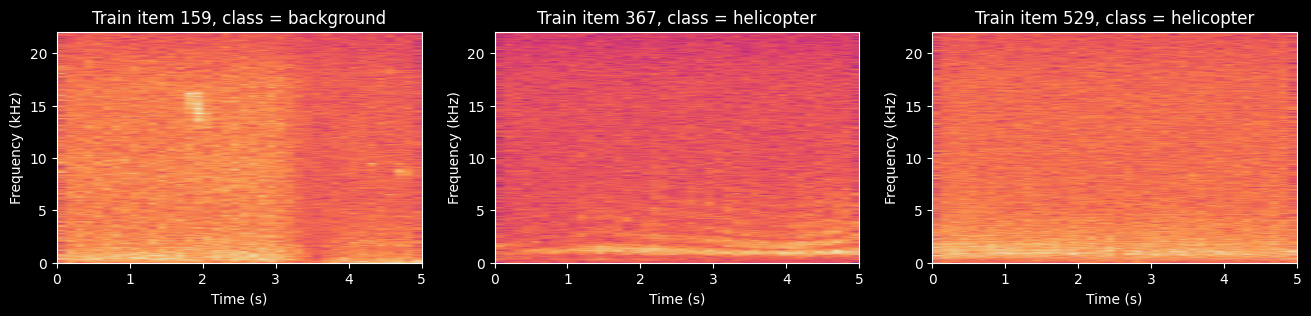

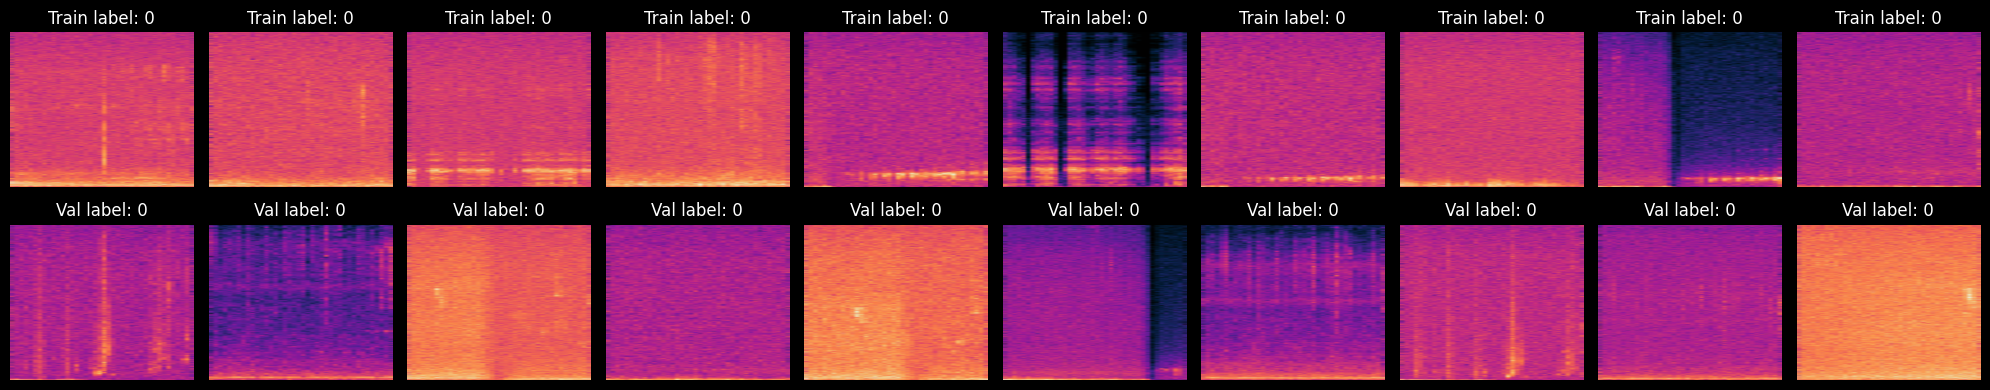

In [50]:
import random

from nbformat import convert
import torchaudio.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Make sure tqdm is installed

from hs_hackathon_drone_acoustics import CLASSES, RAW_DATA_DIR
from hs_hackathon_drone_acoustics.base import AudioDataset

RAW_DATA_DIR = Path("/home/henrik/Documents/EDTH/CPH2025/drone_acoustics_train_val_data")

TRAIN_PATH = RAW_DATA_DIR / "train"
VAL_PATH = RAW_DATA_DIR / "val"

train_dataset = AudioDataset(root_dir=TRAIN_PATH)
val_dataset = AudioDataset(root_dir=VAL_PATH)

# Let's plot some examples from the training dataset
fig, axes = plt.subplots(1, 3, figsize=(16, 3))
for ax in axes:
    idx = random.randint(0, len(train_dataset))
    print(idx)
    waveform, label = train_dataset[idx]
    plot_spectrogram(waveform, ax)
    ax.set_title(f"Train item {idx}, class = {CLASSES[label]}")
    
    
def convert_to_mtx(waveform):
    resample = T.Resample(waveform.sample_rate, 16_000)
    waveform_to_spectrogram = T.Spectrogram(win_length=4096, n_fft=4096, hop_length=2048)
    db_transform = T.AmplitudeToDB(stype="power", top_db=80)
    spectrogram = db_transform(waveform_to_spectrogram(resample(waveform.data)))
    return spectrogram
    
# Check dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Plot 10 samples from each dataset
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Train samples
    X, y = train_dataset[i]
    img = convert_to_mtx(X)
    axes[0, i].imshow(img.numpy(), aspect="auto", origin="lower")
    axes[0, i].set_title(f"Train label: {y}")
    axes[0, i].axis("off")
    # Validation samples
    Xv, yv = val_dataset[i]
    img = convert_to_mtx(Xv)
    axes[1, i].imshow(img.numpy(), aspect="auto", origin="lower")
    axes[1, i].set_title(f"Val label: {yv}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()
    

In [80]:
def create_chunks(mtx, n):
    chunk_size = mtx.shape[0] // n
    chunks = [mtx[i*chunk_size:(i+1)*chunk_size, :] for i in range(n)]
    return chunks

spectogram_chunks_train = []
labels_train = []

n_chunks = 2

print("Train samples:", len(train_dataset))
for sample in train_dataset:
    waveform, label = sample
    mtx = convert_to_mtx(waveform)
    chunks = create_chunks(mtx, n_chunks)
    spectogram_chunks_train += chunks
    labels_train += [label for i in range(len(chunks))]
    
print("Train labels", len(labels_train))
    
spectogram_chunks_val = []
labels_val = []

print("Val samples:", len(val_dataset))
for sample in val_dataset:
    waveform, label = sample
    mtx = convert_to_mtx(waveform)
    chunks = create_chunks(mtx, n_chunks)
    # print(len(chunks))
    spectogram_chunks_val += chunks
    labels_val += [label for i in range(len(chunks))]

print("Val labels", len(labels_val))
# plt.hist(labels_train)
# plt.show()
# plt.hist(labels_val)
# plt.show()

Train samples: 540
Train labels 1080
Val samples: 180
Val labels 360


In [81]:
from torch.utils.data import Dataset
class FastTensorDataset(Dataset):
    def __init__(self, tensors, labels):
        self.tensors = tensors  # List of torch.Tensor
        self.labels = torch.tensor(labels)  # List or tensor of labels

    def __getitem__(self, idx):
        return self.tensors[idx], self.labels[idx]

    def __len__(self):
        return len(self.tensors)

In [ ]:
batch_size = 96
train_ds_torch = FastTensorDataset(spectogram_chunks_train, labels_train)
val_ds_torch = FastTensorDataset(spectogram_chunks_val, labels_val)
train_loader = DataLoader(train_ds_torch, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds_torch, batch_size=batch_size)

Train dataset size: 1080
Validation dataset size: 360


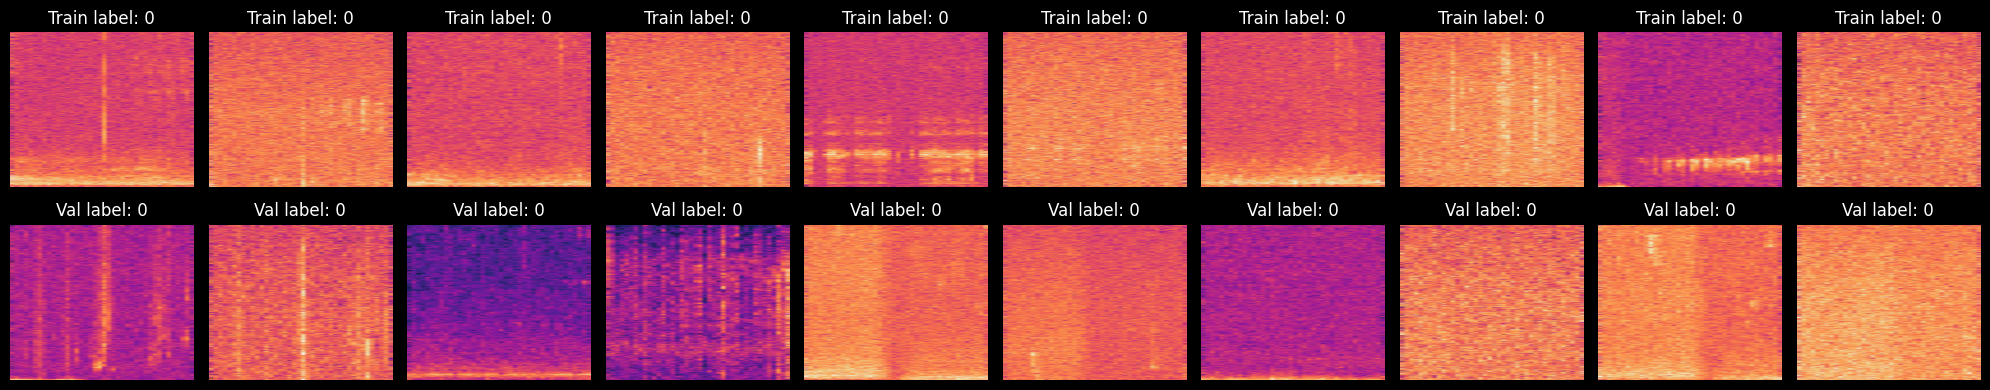

In [83]:
# Check dataset sizes
print(f"Train dataset size: {len(train_ds_torch)}")
print(f"Validation dataset size: {len(val_ds_torch)}")

# Plot 10 samples from each dataset
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Train samples
    X, y = train_ds_torch[i]
    axes[0, i].imshow(X.cpu().numpy(), aspect="auto", origin="lower")
    axes[0, i].set_title(f"Train label: {y.item()}")
    axes[0, i].axis("off")
    # Validation samples
    Xv, yv = val_ds_torch[i]
    axes[1, i].imshow(Xv.cpu().numpy(), aspect="auto", origin="lower")
    axes[1, i].set_title(f"Val label: {yv.item()}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [84]:
#  List available CUDA devices
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA devices available.")

Number of GPUs: 1
Device 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [ ]:
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.features(x)
        x = self.classifier(x)
        return x

input_shape = spectogram_chunks_train[0].shape
num_classes = len(set(labels_train))
model = SpectrogramCNN(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
for epoch in range(100):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for X, y in progress_bar:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Validation accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
print(f"Validation accuracy: {correct / total:.2%}")


Epoch 1: 100%|██████████| 23/23 [00:01<00:00, 17.54it/s]


Epoch 1, Loss: 0.9417


Epoch 2: 100%|██████████| 23/23 [00:01<00:00, 17.87it/s]


Epoch 2, Loss: 0.8553


Epoch 3: 100%|██████████| 23/23 [00:01<00:00, 17.79it/s]


Epoch 3, Loss: 1.1238


Epoch 4: 100%|██████████| 23/23 [00:01<00:00, 17.79it/s]


Epoch 4, Loss: 0.8717


Epoch 5: 100%|██████████| 23/23 [00:01<00:00, 17.79it/s]


Epoch 5, Loss: 1.0139


Epoch 6: 100%|██████████| 23/23 [00:01<00:00, 17.74it/s]


Epoch 6, Loss: 0.9187


Epoch 7: 100%|██████████| 23/23 [00:01<00:00, 17.72it/s]


Epoch 7, Loss: 0.8812


Epoch 8: 100%|██████████| 23/23 [00:01<00:00, 17.69it/s]


Epoch 8, Loss: 0.8675


Epoch 9: 100%|██████████| 23/23 [00:01<00:00, 17.69it/s]


Epoch 9, Loss: 0.7736


Epoch 10: 100%|██████████| 23/23 [00:01<00:00, 17.64it/s]


Epoch 10, Loss: 0.9308


Epoch 11: 100%|██████████| 23/23 [00:01<00:00, 17.67it/s]


Epoch 11, Loss: 0.8949


Epoch 12: 100%|██████████| 23/23 [00:01<00:00, 17.66it/s]


Epoch 12, Loss: 0.9555


Epoch 13: 100%|██████████| 23/23 [00:01<00:00, 17.63it/s]


Epoch 13, Loss: 0.8427


Epoch 14: 100%|██████████| 23/23 [00:01<00:00, 17.61it/s]


Epoch 14, Loss: 0.8430


Epoch 15: 100%|██████████| 23/23 [00:01<00:00, 17.61it/s]


Epoch 15, Loss: 0.8064


Epoch 16: 100%|██████████| 23/23 [00:01<00:00, 17.56it/s]


Epoch 16, Loss: 0.8918


Epoch 17: 100%|██████████| 23/23 [00:01<00:00, 17.57it/s]


Epoch 17, Loss: 0.7410


Epoch 18: 100%|██████████| 23/23 [00:01<00:00, 17.60it/s]


Epoch 18, Loss: 0.8100


Epoch 19: 100%|██████████| 23/23 [00:01<00:00, 17.56it/s]


Epoch 19, Loss: 0.8464


Epoch 20: 100%|██████████| 23/23 [00:01<00:00, 17.53it/s]


Epoch 20, Loss: 0.7931


Epoch 21: 100%|██████████| 23/23 [00:01<00:00, 17.56it/s]


Epoch 21, Loss: 0.8619


Epoch 22: 100%|██████████| 23/23 [00:01<00:00, 17.53it/s]


Epoch 22, Loss: 0.9316


Epoch 23: 100%|██████████| 23/23 [00:01<00:00, 17.54it/s]


Epoch 23, Loss: 0.8574


Epoch 24: 100%|██████████| 23/23 [00:01<00:00, 17.53it/s]


Epoch 24, Loss: 0.8378


Epoch 25: 100%|██████████| 23/23 [00:01<00:00, 17.52it/s]


Epoch 25, Loss: 1.0174


Epoch 26: 100%|██████████| 23/23 [00:01<00:00, 17.50it/s]


Epoch 26, Loss: 0.8062


Epoch 27: 100%|██████████| 23/23 [00:01<00:00, 17.52it/s]


Epoch 27, Loss: 1.0226


Epoch 28: 100%|██████████| 23/23 [00:01<00:00, 17.51it/s]


Epoch 28, Loss: 0.7775


Epoch 29: 100%|██████████| 23/23 [00:01<00:00, 17.50it/s]


Epoch 29, Loss: 1.0445


Epoch 30: 100%|██████████| 23/23 [00:01<00:00, 17.51it/s]


Epoch 30, Loss: 0.8943


Epoch 31: 100%|██████████| 23/23 [00:01<00:00, 17.50it/s]


Epoch 31, Loss: 0.8256


Epoch 32: 100%|██████████| 23/23 [00:01<00:00, 17.48it/s]


Epoch 32, Loss: 0.8739


Epoch 33: 100%|██████████| 23/23 [00:01<00:00, 17.46it/s]


Epoch 33, Loss: 0.8174


Epoch 34: 100%|██████████| 23/23 [00:01<00:00, 17.49it/s]


Epoch 34, Loss: 0.8883


Epoch 35: 100%|██████████| 23/23 [00:01<00:00, 17.47it/s]


Epoch 35, Loss: 0.9411


Epoch 36: 100%|██████████| 23/23 [00:01<00:00, 17.47it/s]


Epoch 36, Loss: 0.9158


Epoch 37: 100%|██████████| 23/23 [00:01<00:00, 17.50it/s]


Epoch 37, Loss: 0.9852


Epoch 38: 100%|██████████| 23/23 [00:01<00:00, 17.47it/s]


Epoch 38, Loss: 0.7507


Epoch 39: 100%|██████████| 23/23 [00:01<00:00, 17.49it/s]


Epoch 39, Loss: 0.8302


Epoch 40: 100%|██████████| 23/23 [00:01<00:00, 17.50it/s]


Epoch 40, Loss: 0.7549


Epoch 41: 100%|██████████| 23/23 [00:01<00:00, 17.44it/s]


Epoch 41, Loss: 0.7829


Epoch 42: 100%|██████████| 23/23 [00:01<00:00, 16.83it/s]


Epoch 42, Loss: 0.7688


Epoch 43: 100%|██████████| 23/23 [00:01<00:00, 17.09it/s]


Epoch 43, Loss: 0.7694


Epoch 44: 100%|██████████| 23/23 [00:01<00:00, 15.99it/s]


Epoch 44, Loss: 0.9843


Epoch 45: 100%|██████████| 23/23 [00:01<00:00, 14.87it/s]


Epoch 45, Loss: 0.9563


Epoch 46: 100%|██████████| 23/23 [00:01<00:00, 17.42it/s]


Epoch 46, Loss: 1.0051


Epoch 47: 100%|██████████| 23/23 [00:01<00:00, 17.57it/s]


Epoch 47, Loss: 0.8152


Epoch 48: 100%|██████████| 23/23 [00:01<00:00, 17.42it/s]


Epoch 48, Loss: 0.6692


Epoch 49: 100%|██████████| 23/23 [00:01<00:00, 16.78it/s]


Epoch 49, Loss: 0.8097


Epoch 50: 100%|██████████| 23/23 [00:01<00:00, 17.24it/s]


Epoch 50, Loss: 1.0210


Epoch 51: 100%|██████████| 23/23 [00:01<00:00, 16.73it/s]


Epoch 51, Loss: 0.9040


Epoch 52: 100%|██████████| 23/23 [00:01<00:00, 15.63it/s]


Epoch 52, Loss: 1.0411


Epoch 53: 100%|██████████| 23/23 [00:01<00:00, 16.69it/s]


Epoch 53, Loss: 0.9137


Epoch 54: 100%|██████████| 23/23 [00:01<00:00, 16.63it/s]


Epoch 54, Loss: 0.7797


Epoch 55: 100%|██████████| 23/23 [00:01<00:00, 16.59it/s]


Epoch 55, Loss: 1.0472


Epoch 56: 100%|██████████| 23/23 [00:01<00:00, 17.58it/s]


Epoch 56, Loss: 0.8743


Epoch 57: 100%|██████████| 23/23 [00:01<00:00, 17.53it/s]


Epoch 57, Loss: 1.0899


Epoch 58: 100%|██████████| 23/23 [00:01<00:00, 16.88it/s]


Epoch 58, Loss: 0.9405


Epoch 59: 100%|██████████| 23/23 [00:01<00:00, 17.27it/s]


Epoch 59, Loss: 1.0074


Epoch 60: 100%|██████████| 23/23 [00:01<00:00, 17.52it/s]


Epoch 60, Loss: 0.8270


Epoch 61: 100%|██████████| 23/23 [00:01<00:00, 14.65it/s]


Epoch 61, Loss: 0.9279


Epoch 62: 100%|██████████| 23/23 [00:01<00:00, 17.52it/s]


Epoch 62, Loss: 0.8026


Epoch 63: 100%|██████████| 23/23 [00:01<00:00, 17.44it/s]


Epoch 63, Loss: 0.9562


Epoch 64: 100%|██████████| 23/23 [00:01<00:00, 16.03it/s]


Epoch 64, Loss: 1.0331


Epoch 65: 100%|██████████| 23/23 [00:01<00:00, 17.22it/s]


Epoch 65, Loss: 0.8550


Epoch 66: 100%|██████████| 23/23 [00:01<00:00, 17.13it/s]


Epoch 66, Loss: 0.8957


Epoch 67: 100%|██████████| 23/23 [00:01<00:00, 16.84it/s]


Epoch 67, Loss: 0.8705


Epoch 68: 100%|██████████| 23/23 [00:01<00:00, 17.22it/s]


Epoch 68, Loss: 0.7397


Epoch 69: 100%|██████████| 23/23 [00:01<00:00, 17.40it/s]


Epoch 69, Loss: 0.8219


Epoch 70: 100%|██████████| 23/23 [00:01<00:00, 17.54it/s]


Epoch 70, Loss: 0.6984


Epoch 71: 100%|██████████| 23/23 [00:01<00:00, 17.26it/s]


Epoch 71, Loss: 0.7321


Epoch 72: 100%|██████████| 23/23 [00:01<00:00, 16.78it/s]


Epoch 72, Loss: 0.9609


Epoch 73: 100%|██████████| 23/23 [00:01<00:00, 17.14it/s]


Epoch 73, Loss: 0.8333


Epoch 74: 100%|██████████| 23/23 [00:01<00:00, 17.56it/s]


Epoch 74, Loss: 0.9415


Epoch 75: 100%|██████████| 23/23 [00:01<00:00, 15.69it/s]


Epoch 75, Loss: 0.8663


Epoch 76: 100%|██████████| 23/23 [00:01<00:00, 17.19it/s]


Epoch 76, Loss: 0.7282


Epoch 77: 100%|██████████| 23/23 [00:01<00:00, 17.57it/s]


Epoch 77, Loss: 0.7845


Epoch 78: 100%|██████████| 23/23 [00:01<00:00, 17.57it/s]


Epoch 78, Loss: 0.8435


Epoch 79: 100%|██████████| 23/23 [00:01<00:00, 17.51it/s]


Epoch 79, Loss: 0.7073


Epoch 80: 100%|██████████| 23/23 [00:01<00:00, 16.88it/s]


Epoch 80, Loss: 0.7838


Epoch 81: 100%|██████████| 23/23 [00:01<00:00, 14.46it/s]


Epoch 81, Loss: 0.8117


Epoch 82: 100%|██████████| 23/23 [00:01<00:00, 17.25it/s]


Epoch 82, Loss: 1.0086


Epoch 83: 100%|██████████| 23/23 [00:01<00:00, 17.47it/s]


Epoch 83, Loss: 0.7755


Epoch 84: 100%|██████████| 23/23 [00:01<00:00, 17.09it/s]


Epoch 84, Loss: 0.8531


Epoch 85: 100%|██████████| 23/23 [00:01<00:00, 14.80it/s]


Epoch 85, Loss: 0.6950


Epoch 86: 100%|██████████| 23/23 [00:01<00:00, 15.75it/s]


Epoch 86, Loss: 0.9322


Epoch 87: 100%|██████████| 23/23 [00:01<00:00, 17.55it/s]


Epoch 87, Loss: 0.8645


Epoch 88:  26%|██▌       | 6/23 [00:00<00:00, 19.29it/s]